In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid

In [126]:
df=pd.read_csv( "data/donnees_preprocesse_pour_modelisation.csv", sep=",")

In [127]:
data=df.copy()

- On veut modéliser la hauteur moyenne des vagues hautes 1h à l'avance donc à T+1 pour St Nazaré
- On va enlever les données non nécessaires du data set les lag allant de 2 à 23 (pour éviter que ça soit redondant)
- Ajouter lag 1 pour la variable hauteur moyenne des vagues hautes pour les autres balises
- Pour avoir la variable cible il faut shifter cette dernière

In [128]:
data.head()

,Temps moyen entre les vagues,Direction moyenne des vagues,Période des vagues énergétiques,Hauteur moyenne des vagues les plus hautes,temps_moyen_entre_les_vagues_2016_2017_1129,direction_moyene_des_vagues_2016_2017_1129,temps_moyen_entre_les_vagues_energetiques_2016_2017_1129,hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129,temps_moyen_entre_les_vagues_2016_2017_1118,direction_moyene_des_vagues_2016_2017_1118,...,Hauteur moyenne des vagues les plus hautes_lag_22,Hauteur moyenne des vagues les plus hautes_lag_23,Hauteur moyenne des vagues les plus hautes_rolling_mean_24h,Hauteur moyenne des vagues les plus hautes_rolling_std_24h,hour,hour_sin,hour_cos,Hauteur moyenne des vagues les plus hautes_target,month,season
0,10.277721,0.334779,14.730517,3.490737,10.861396,0.424323,14.690897,4.170059,10.749910,0.426009,...,2.614599,2.581360,3.089948,0.292237,23,-0.258819,0.965926,2.515582,1,0
1,10.254212,0.335589,14.743447,3.501528,10.844849,0.426131,14.710769,4.184670,10.738215,0.427954,...,2.654079,2.614599,3.128288,0.282821,0,0.000000,1.000000,2.463134,1,0
2,10.228110,0.336257,14.753474,3.509845,10.825637,0.427837,14.728780,4.196269,10.723679,0.429793,...,2.702538,2.654079,3.165590,0.270911,1,0.258819,0.965926,2.413333,1,0
3,10.199312,0.336771,14.760477,3.515597,10.803640,0.429431,14.744819,4.204734,10.706166,0.431511,...,2.760034,2.702538,3.201486,0.256902,2,0.500000,0.866025,2.366782,1,0
4,10.168637,0.337242,14.765240,3.519368,10.779817,0.431023,14.759665,4.210864,10.686752,0.433232,...,2.817256,2.760034,3.235521,0.241577,3,0.707107,0.707107,2.321984,1,0


In [129]:
# Supprimer les lag allant de 3 à 23 pour Hauteur moyenne des vagues les plus hautes
cols_lag_drop = [f"Hauteur moyenne des vagues les plus hautes_lag_{i}" for i in range(3, 24)]
data = data.drop(columns=cols_lag_drop)

In [130]:
# Lag pour St Nazaré
columns_to_lag = ['Direction moyenne des vagues', 'Temps moyen entre les vagues']
lags = [1, 2, 3]

for column in columns_to_lag:
    for lag in lags:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)

In [131]:
# Lag pour St Nazaré
columns_to_lag = ['Hauteur moyenne des vagues les plus hautes']
lags = [1, 2]

for column in columns_to_lag:
    for lag in lags:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)

In [132]:
# Temps moyen entre les vagues avec un lag de 1
data['Période des vagues énergétiques_lag_1'] = data['Période des vagues énergétiques'].shift(1)

In [133]:
# Liste des colonnes sur lesquelles appliquer le rolling window
columns_to_lag = [
    'temps_moyen_entre_les_vagues_2016_2017_1129',
    'direction_moyene_des_vagues_2016_2017_1129',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1129',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129',
    'temps_moyen_entre_les_vagues_2016_2017_1118',
    'direction_moyene_des_vagues_2016_2017_1118',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1118',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1118',
    'temps_moyen_entre_les_vagues_2016_2017_1119',
    'direction_moyene_des_vagues_2016_2017_1119',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1119',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1119'
]

# Appliquer le rolling mean avec une fenêtre de taille 3 (t, t-1, t-2)
for column in columns_to_lag:
    data[f'{column}_rolling_mean_2'] = data[column].rolling(window=3).mean()


In [134]:
# Création de la cible (T+1)
data['target'] = data['Hauteur moyenne des vagues les plus hautes'].shift(-1)
# En raison du shift, il n'y aura pas de T+1 pour la dernière observation (on l'a supprime donc)
data = data.dropna(subset=['target'])

In [135]:
print(data[['Hauteur moyenne des vagues les plus hautes', 'target']].head(10))
# pour voir si le décalage ets bon et me semble que oui

   Hauteur moyenne des vagues les plus hautes    target
0                                    3.490737  3.501528
1                                    3.501528  3.509845
2                                    3.509845  3.515597
3                                    3.515597  3.519368
4                                    3.519368  3.521430
5                                    3.521430  3.515879
6                                    3.515879  3.501259
7                                    3.501259  3.481247
8                                    3.481247  3.455081
9                                    3.455081  3.417871


In [136]:
data = data.drop(columns=['Hauteur moyenne des vagues les plus hautes_target'])

In [137]:
# Supprimer les lignes contenant des valeurs manquantes car avec les lag etc il y a des NaN et il faut allignement
data = data.dropna()

- La transforlation cos/sin de l'heure permet d'éviter que le modèle pense que 23h et 0 sont très éloignés 
- rolling_mean_24h : Capture la tendance générale des vagues sur les 24 dernières heures.
- rolling_std_24h : Capture la variabilité des vagues sur cette période (haute si les vagues sont irrégulières, basse si elles sont stables).

==> à discuter si l'on garde ou non


In [138]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temps moyen entre les vagues,17493.0,6.975805e+00,1.949236,3.007394,5.336303,6.743827e+00,8.335800,12.794645
Direction moyenne des vagues,17493.0,3.836042e-01,0.325994,-0.962609,0.242409,4.592951e-01,0.616456,0.940346
Période des vagues énergétiques,17493.0,1.109539e+01,2.155144,4.502103,9.386760,1.114243e+01,12.765364,17.357317
Hauteur moyenne des vagues les plus hautes,17493.0,1.311717e+00,0.656163,0.326232,0.881526,1.125520e+00,1.582824,4.445147
temps_moyen_entre_les_vagues_2016_2017_1129,17493.0,7.217241e+00,1.943467,3.298572,5.576914,6.981066e+00,8.606368,13.137815
direction_moyene_des_vagues_2016_2017_1129,17493.0,4.529849e-01,0.314487,-0.948593,0.333762,5.283198e-01,0.674281,0.993520
temps_moyen_entre_les_vagues_energetiques_2016_2017_1129,17493.0,1.115221e+01,2.142223,4.646813,9.495199,1.122055e+01,12.785595,17.253552
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129,17493.0,1.574254e+00,0.756362,0.396054,1.067270,1.370676e+00,1.898922,5.366242
temps_moyen_entre_les_vagues_2016_2017_1118,17493.0,7.122518e+00,1.903154,3.154718,5.536043,6.874262e+00,8.471097,13.005015
direction_moyene_des_vagues_2016_2017_1118,17493.0,4.650207e-01,0.330927,-0.984702,0.338468,5.472708e-01,0.700713,1.011016


### Modélisation

### J'ai enlevé hour month et season

In [139]:
# Trier les données par index temporel 
series_data = data.sort_index()

# Séparer les features et la target 
features = series_data.drop(columns=["target","hour","month", "season"])
target = series_data["target"]

In [ ]:
# Choix des métriques en faisant un GridSearch sur 3 fenêtres (voir plus bas)

In [121]:
# Séparation du jeu de test final
test_size = 5000  # Dernières observations réservées au test
test_start = len(series_data) - test_size

X_test, y_test = features.iloc[test_start:], target.iloc[test_start:]

# Vérification des tailles
print(f"Total observations: {len(series_data)}")
print(f"Training + Validation observations: {test_start}")
print(f"Test observations: {len(X_test)}")

# Sliding Window Training & Validation
window_size = 3000  
horizon = 500       
step_size = 2000    

mae_scores = []
rmse_scores = []

# 🔹 Correction de la borne supérieure 🔹
for start in range(0, test_start - window_size, step_size):  
    train_start = start
    train_end = start + window_size
    val_end = train_end + horizon
    
    X_train, y_train = features.iloc[train_start:train_end], target.iloc[train_start:train_end]
    X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]

    # Initialisation du modèle
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        random_state=42
    )

    # Entraînement
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Prédiction
    y_val_pred = model.predict(X_val)

    # Évaluation
    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fenêtre {start} → {val_end}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Moyenne des scores de validation
print(f"\nMAE moyen validation: {np.mean(mae_scores):.4f}")
print(f"RMSE moyen validation: {np.mean(rmse_scores):.4f}")

# 🔹 Dernier modèle entraîné utilisé pour le test final 🔹
y_test_pred = model.predict(X_test)

# Évaluation finale sur test
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n🔹 Performance finale sur TEST 🔹")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")


Total observations: 17493
Training + Validation observations: 12493
Test observations: 5000


Fenêtre 0 → 3500: MAE=0.0091, RMSE=0.0119
Fenêtre 2000 → 5500: MAE=0.0181, RMSE=0.0416
Fenêtre 4000 → 7500: MAE=0.1352, RMSE=0.4005
Fenêtre 6000 → 9500: MAE=0.0159, RMSE=0.0232
Fenêtre 8000 → 11500: MAE=0.0384, RMSE=0.0603

MAE moyen validation: 0.0433
RMSE moyen validation: 0.1075

🔹 Performance finale sur TEST 🔹
MAE Test: 0.0193
RMSE Test: 0.0364


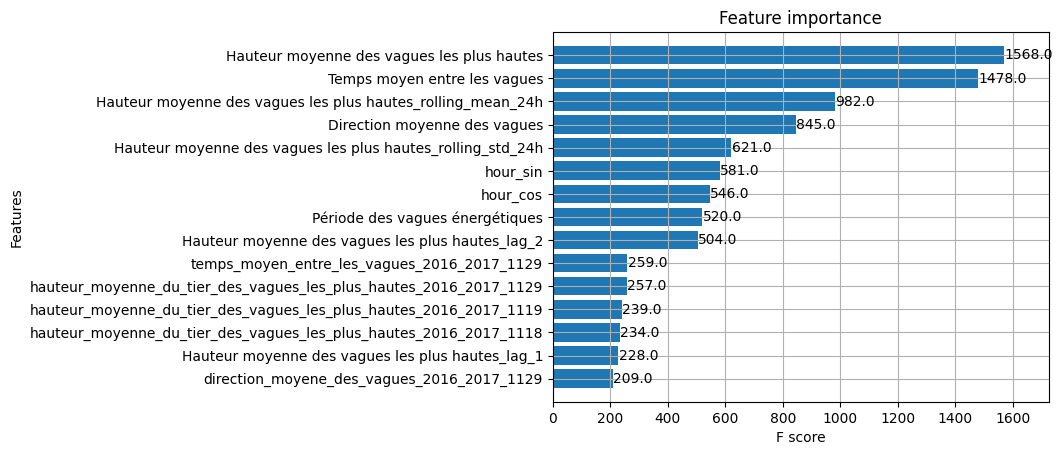

In [122]:
# Importance des variables
xgb.plot_importance(model, height=0.8, max_num_features=15)
plt.show()

In [123]:
#Essayer de faire GridSearch sur 3 fênetres et garder 5000 obs pour test contre 2000 avant
#Essayer peut-être de garder 

In [140]:
test_size = 5000
test_start = len(series_data) - test_size

In [141]:
# 🔹 Définition des hyperparamètres à tester 🔹
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],
}

# 🔹 Paramètres du sliding window 🔹
window_size = 3000  
horizon = 500       
step_size = 2000    
num_windows = 3  # Nombre de fenêtres à utiliser pour le GridSearch

best_params = None
best_score = float("inf")  # On cherche à minimiser l'erreur

# 🔹 GridSearch sur plusieurs fenêtres 🔹
for params in ParameterGrid(param_grid):
    mae_scores = []

    for i, start in enumerate(range(0, test_start - window_size, step_size)):
        if i >= num_windows:  # Limite à num_windows fenêtres
            break
        
        train_start = start
        train_end = start + window_size
        val_end = train_end + horizon

        X_train, y_train = features.iloc[train_start:train_end], target.iloc[train_start:train_end]
        X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]

        # Initialisation du modèle avec les hyperparamètres en test
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **params)

        # Entraînement
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

        # Prédiction
        y_val_pred = model.predict(X_val)

        # Évaluation
        mae = mean_absolute_error(y_val, y_val_pred)
        mae_scores.append(mae)

    # Moyenne des performances sur toutes les fenêtres
    avg_mae = np.mean(mae_scores)
    print(f"Params: {params} - MAE moyen: {avg_mae:.4f}")

    # Mise à jour des meilleurs paramètres
    if avg_mae < best_score:
        best_score = avg_mae
        best_params = params

print(f"\n✅ Meilleurs hyperparamètres après GridSearch: {best_params}")

# 🔹 Entraînement final sur toutes les fenêtres restantes 🔹
mae_scores = []
rmse_scores = []

for start in range(0, test_start - window_size, step_size):  
    train_start = start
    train_end = start + window_size
    val_end = train_end + horizon
    
    X_train, y_train = features.iloc[train_start:train_end], target.iloc[train_start:train_end]
    X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]

    # Initialisation du modèle avec les meilleurs hyperparamètres
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **best_params)

    # Entraînement
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Prédiction
    y_val_pred = model.predict(X_val)

    # Évaluation
    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fenêtre {start} → {val_end}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Moyenne des scores de validation
print(f"\nMAE moyen validation: {np.mean(mae_scores):.4f}")
print(f"RMSE moyen validation: {np.mean(rmse_scores):.4f}")

# 🔹 Dernier modèle entraîné utilisé pour le test final 🔹
y_test_pred = model.predict(X_test)

# Évaluation finale sur test
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n🔹 Performance finale sur TEST 🔹")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")


Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200} - MAE moyen: 0.1108
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300} - MAE moyen: 0.0728
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400} - MAE moyen: 0.0596
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200} - MAE moyen: 0.1109
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300} - MAE moyen: 0.0728
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 400} - MAE moyen: 0.0595
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200} - MAE moyen: 0.0547
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300} - MAE moyen: 0.0547
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400} - MAE moyen: 0.0546
Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200} - MAE moyen: 0.0542
Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300} - MAE moyen: 0.0542
Params: {'learning_rate': 

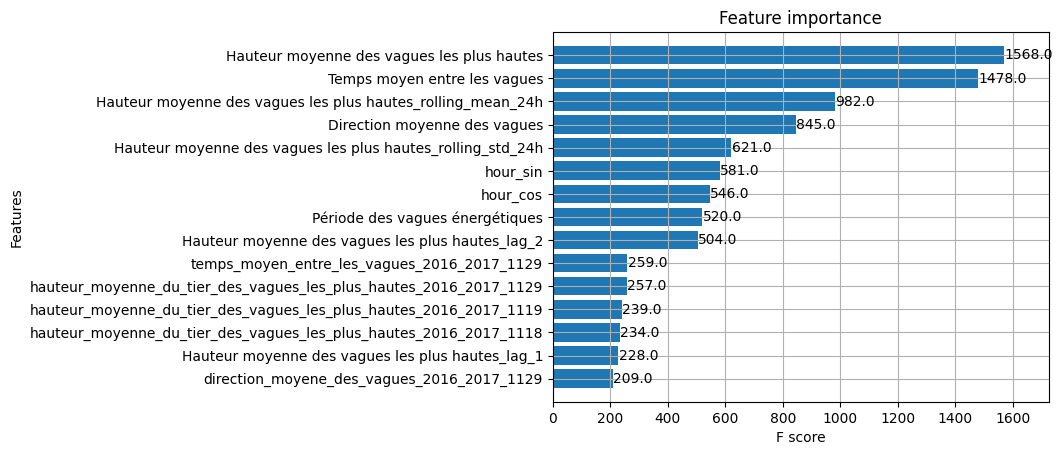

In [142]:
# Importance des variables
xgb.plot_importance(model, height=0.8, max_num_features=15)
plt.show()

In [103]:
print("Distribution des valeurs dans l'entraînement :")
print(target.iloc[:test_start].describe())

print("\nDistribution des valeurs dans le test :")
print(target.iloc[test_start:].describe())


Distribution des valeurs dans l'entraînement :
count    12493.000000
mean         1.414370
std          0.690486
min          0.370880
25%          0.940140
50%          1.211810
75%          1.764006
max          4.445147
Name: target, dtype: float64

Distribution des valeurs dans le test :
count    5000.000000
mean        1.054958
std         0.471207
min         0.326232
25%         0.723583
50%         0.963991
75%         1.212173
max         4.149109
Name: target, dtype: float64


### Ajout du Benchmark

In [145]:
y_pred_benchmark = features["Hauteur moyenne des vagues les plus hautes_rolling_mean_24h"].loc[y_test.index]  # Prendre la valeur du benchmark sur la période de test

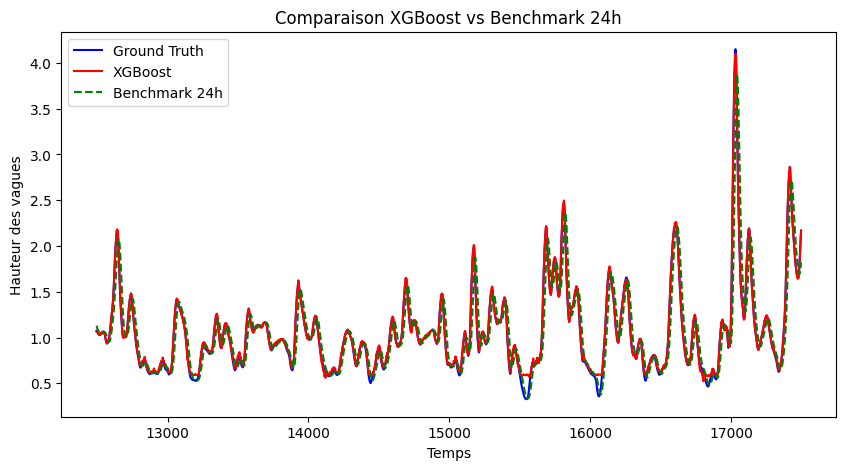

In [146]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Ground Truth', color='blue')
plt.plot(y_test.index, y_test_pred, label='XGBoost', color='red')
plt.plot(y_test.index, y_pred_benchmark, label='Benchmark 24h', color='green', linestyle="dashed")

plt.xlabel('Temps')
plt.ylabel('Hauteur des vagues')
plt.title('Comparaison XGBoost vs Benchmark 24h')
plt.legend()
plt.show()


In [147]:
# 📌 Calcul des performances du benchmark
mae_benchmark = mean_absolute_error(y_test, y_pred_benchmark)
rmse_benchmark = np.sqrt(mean_squared_error(y_test, y_pred_benchmark))

# 📌 Affichage des performances
print(f"📌 XGBoost: MAE = {mae_test:.4f}, RMSE = {rmse_test:.4f}")
print(f"📌 Benchmark 24h: MAE = {mae_benchmark:.4f}, RMSE = {rmse_benchmark:.4f}")

📌 XGBoost: MAE = 0.0193, RMSE = 0.0364
📌 Benchmark 24h: MAE = 0.1314, RMSE = 0.2032
